In [5]:
%load_ext autoreload
%autoreload 2

from montlake.atomgeom.features import get_features,get_D_feats_feats
from montlake.atomgeom.utils import get_atoms_4
from montlake.simulations.rigidethanol import get_rigid_ethanol_data
from montlake.utils.utils import get_234_indices, get_atoms3_full, get_atoms4_full, data_stream_custom_range, get_cosines
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.gradients.estimate import get_grads_pullback
from montlake.statistics.normalization import normalize_L212
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.optimization.utils import get_selected_function_ids,get_selected_functions_lm2
from montlake.utils.replicates import Replicate, get_supports_brute

from megaman.embedding import SpectralEmbedding

import dill as pickle
import os
import sys
import numpy as np
import itertools
from itertools import permutations,combinations
from sklearn.decomposition import TruncatedSVD
import pathos
from pathos.multiprocessing import ProcessingPool as Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#load hyperparameters
n = 10000
natoms = 9
radius = 0.177
n_neighbors = 1000
n_components = 3
ii = np.asarray([0, 0, 0, 0, 1, 1, 1, 2])  # atom adjacencies for dihedral angle computation
jj = np.asarray([1, 2, 3, 4, 5, 6, 7, 8])
nreps = 1
d = 2
nsel = 100 
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
outfile = '/Users/samsonkoelle/manifoldflasso_jmlr/results/rigidethanol.pkl'

In [7]:
#load geometric features
atoms2 = np.asarray(list(itertools.combinations(range(natoms), 2))) 
atoms2full = atoms2
atoms3 = np.asarray(list(itertools.combinations(range(natoms), 3))) 
atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4))) 
atoms3full = get_atoms3_full(atoms3)
atoms4full = get_atoms4_full(atoms4)
atoms4, p = get_atoms_4(natoms, ii, jj)

In [16]:
positions = get_rigid_ethanol_data( xvar=0., noise=False)
var= 0.00001
np.random.multivariate_normal(size = 10000,mean = np.zeros(27),cov= np.identity(27)*0.00001)
positions = positions + 

ValueError: operands could not be broadcast together with shapes (10000,9,3) (10000,27) 

In [14]:
help(np.random.multivariate_normal)

Help on built-in function multivariate_normal:

multivariate_normal(...) method of numpy.random.mtrand.RandomState instance
    multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)
    
    Draw random samples from a multivariate normal distribution.
    
    The multivariate normal, multinormal or Gaussian distribution is a
    generalization of the one-dimensional normal distribution to higher
    dimensions.  Such a distribution is specified by its mean and
    covariance matrix.  These parameters are analogous to the mean
    (average or "center") and variance (standard deviation, or "width,"
    squared) of the one-dimensional normal distribution.
    
    .. note::
        New code should use the ``multivariate_normal`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    mean : 1-D array_like, of length N
        Mean of the N-dimensional distribution.
    cov : 2-D array_like, of shape (N, N)

In [15]:
#np.save('/Users/samsonkoelle/thesis_data/raw_data/rigidethanol_nonoise', positions)

In [6]:
#compute rotation/translation invariant featureization
cores = pathos.multiprocessing.cpu_count() - 1
pool = Pool(cores)
results = pool.map(
    lambda i: get_features(positions[i],
                           atoms2 = np.asarray([]),
                           atoms3 = atoms3full,
                           atoms4 = np.asarray([])),
    data_stream_custom_range(list(range(n))))
data = np.vstack([np.hstack(results[i]) for i in range(n)])

In [9]:
atoms3full.shape

(252, 3)

In [6]:
#apply SVD
svd = TruncatedSVD(n_components=50)
data_svd = svd.fit_transform(data)

In [7]:
#compute geometry
geom = get_geom(data_svd, radius, n_neighbors) 

In [8]:
#compute embedding
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data_svd)

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [9]:
#preprocess
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data_svd, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    D_feats_feats = np.asarray([get_D_feats_feats(positions[replicates[r].selected_points[i]],
               atoms2in = np.asarray([]), 
               atoms3in = atoms3full, 
               atoms4in = np.asarray([]), 
               atoms2out = np.asarray([]), 
               atoms3out = np.asarray([]),
               atoms4out = atoms4) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([svd.transform(D_feats_feats[i].transpose()).transpose() for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data_svd,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    

In [10]:
#run manifold lasso
for r in range(nreps):
    replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)
    replicates[r].get_ordered_axes()
    replicates[r].sel_l = replicates[r].get_selection_lambda()

initializing lambda search
converged 10.283451578530386
0 5.141725789265193 probe
we did it [0 9]


In [14]:
#get manifold lasso support
selected_functions_unique = np.asarray(np.unique(get_selected_function_ids(replicates,d)), dtype = int)
supports_lasso = get_supports_lasso(replicates,p,d)

#get two stage support
selected_functions_lm2 = get_selected_functions_lm2(replicates)
supports_brute = get_supports_brute(replicates,nreps,p,d,selected_functions_lm2)
selected_functions_unique_twostage  = np.asarray(np.where(supports > 0.)[0], dtype = int)

/Users/samsonkoelle/tunatostada/montlake/statistics/basispursuit.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bp_coeffs[i, j] = np.linalg.lstsq(X[i, :, parameterizations_possible[j]], Y[i])[0]


In [15]:
pool.close()
pool.restart()

In [20]:
#compute function values for plotting
selected_function_values = pool.map(
                lambda i: get_features(positions[i],
                                       atoms2 = np.asarray([]),
                                       atoms3 = np.asarray([]),
                                       atoms4 = atoms4[selected_functions_unique]),
                data_stream_custom_range(list(range(n))))

selected_function_values_array = np.vstack([np.hstack(selected_function_values[i]) for i in range(n)])

selected_function_values_brute = pool.map(
                lambda i: get_features(positions[i],
                                       atoms2 = np.asarray([]),
                                       atoms3 = np.asarray([]),
                                       atoms4 = atoms4[selected_functions_unique_twostage]),
                data_stream_custom_range(list(range(n))))

selected_function_values_array_brute = np.vstack([np.hstack(selected_function_values_brute[i]) for i in range(n)])

In [ ]:
#remove large gradient arrays
replicates_small = {}
for r in range(nreps):
    replicates_small[r] = Replicate(nsel=nsel, n=experiment.M.data.shape[0],
                                    selected_points=replicates[r].selected_points)
    replicates_small[r].dg_M = replicates[r].dg_M
    replicates_small[r].dphispectral_M = replicates[r].dphispectral_M
    cosine = get_cosines(np.swapaxes(replicates[r].dg_M,1,2))
    replicates_small[r].cosine_abs = np.mean(np.abs(cosine), axis = 0)
    
#prepare to save
results = {}
results['replicates_small'] = replicates_small
results['embed'] = embedding
results['data'] = data_svd
results['supports_brute'] = supports_brute
results['supports_lasso'] = supports_lasso
results['cosine_abs'] = cosine_abs
results['selected_function_values'] = selected_function_values
results['selected_function_values_brute'] = selected_function_values_brute
results['selected_functions_unique'] = selected_functions_unique
results['selected_functions_unique_twostage'] = selected_functions_unique_twostage

#save
with open(outfile,'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ols_norms = {}
# for r in range(nreps):
#     psmall = len(selected_functions_lm2[r])
#     ols_norms= np.zeros(tuple(np.concatenate([[nreps], np.repeat(psmall,d)])))
#     basispursuit_losses_subset = get_basispursuit_losses(replicates[r].dg_M[:,:,selected_functions_lm2[r]],replicates[r].dphispectral_M_normalized)
#     ols_norms[r] = basispursuit_losses_subset
#     #ols_norms

In [67]:
xxx = get_basispursuit_losses(replicates[0].dg_M,replicates[0].dphispectral_M_normalized)

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


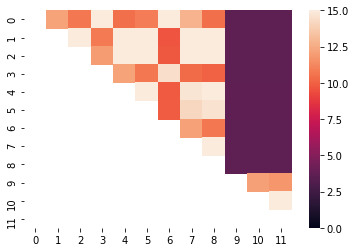

In [83]:
import seaborn as sns
sns.heatmap(np.log(xxx), vmin = 0, vmax = 15)

In [ ]:
get_basispursuit_losses(replicates[r].dg_M, replicates[r].df_M)

In [24]:
X = replicates[r].dg_M[:]
Y = replicates[r].dphispectral_M_normalized

In [26]:
from itertools import combinations

In [21]:
selected_function_values_array = np.vstack([np.hstack(selected_function_values[i]) for i in range(n)]).shape

NameError: name 'selected_function_values' is not defined

In [22]:
selected_functions_lm2

{0: array([0, 6, 9])}

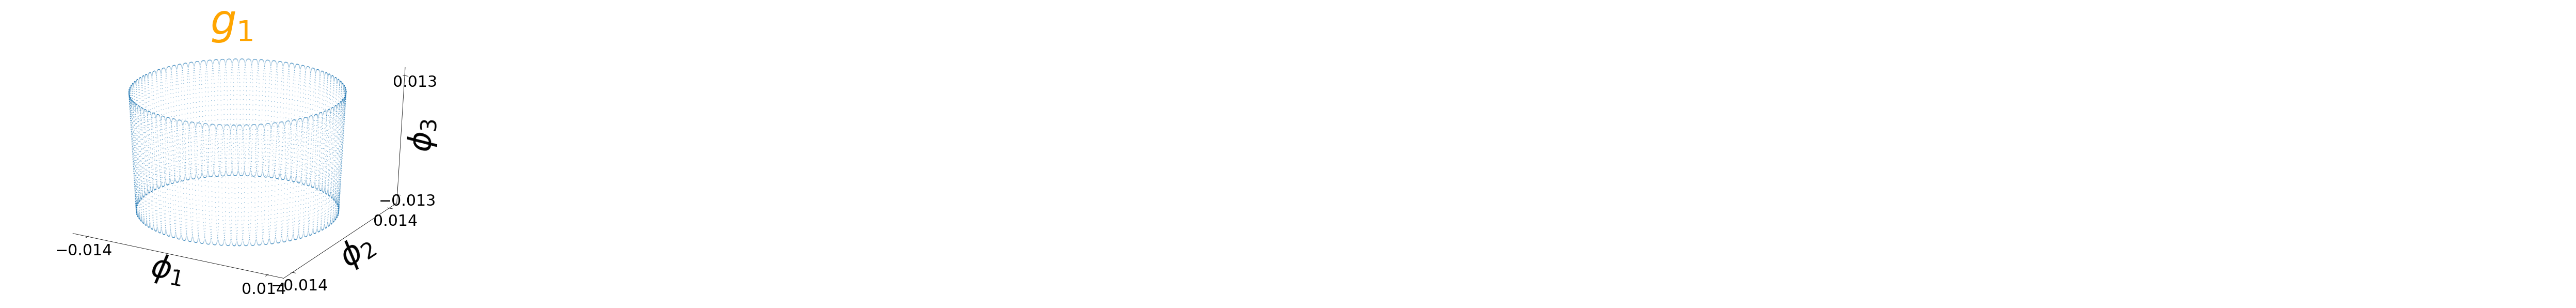

In [ ]:
# diffusion_time = 0.05
# #diffusion_time = 1
# dim = 2
# import numpy as np
# (diffusion_time * (diffusion_time * np.pi * 4)**(dim/2))**(0.5)

In [ ]:
#compute and save selected torsions
#save manifolds
#save results

#     dim = experiment.dim
#     dnoise = experiment.dnoise
#     nreps = experiment.nreps
#     nsel = experiment.nsel
#     p = experiment.p

#     parameterizations_possible = np.asarray(list(combinations(range(experiment.p), dnoise)))
#     nparameterizations_possible = parameterizations_possible.shape[0]
#     supports_brute = {}
#     penalties = np.zeros((nreps, nparameterizations_possible))
#     ols_norm  = np.zeros((nreps,d))
#     for r in range(nreps):
#         brute_coeffs = np.zeros((nsel, nparameterizations_possible, experiment.dim, experiment.q))
#         orthogonality = np.zeros((nsel, nparameterizations_possible))
#         for i in range(nsel):
#             for j in range(nparameterizations_possible):
#                 brute_coeffs[i, j] = np.linalg.lstsq(replicates[r].dg_M[i, parameterizations_possible[j], :], replicates[r].df_M[i])[0]
#                 # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
#         for j in range(nparameterizations_possible):
#             penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
#         for j in range(nparameterizations_possible):
#             ols_norm[r, parameterizations_possible[j][0], parameterizations_possible[j][1]] = penalties[r, j]
#             ols_norm[r, parameterizations_possible[j][1], parameterizations_possible[j][0]] = penalties[r, j]
#         supports_brute[r] = parameterizations_possible[penalties[r, :].argmin()]
#     return (ols_norm, supports_brute)